## 1 - Carrega informações do dataframe  
## 2 - Criação do encoder e da matriz binária para cada coluna que iremos usar para classificação  
## 3 - gera o corpus (bag of words) e vetoriza   
## 4 - Faz a transformação TFIDF  
## 5 - Cria bases de treinamento e validação  
## 6 - Cria modelo  
## 7 - Analisa a acurária e a perda de cada modelo  
## 8 - Cria predições para cada modelo treinado
## 9 - Aplica o modelo na base completa e analisa resultados  

In [1]:
import pandas as pd
import numpy as np
import random
import os 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from collections import namedtuple
from typing import Dict


## 1 - Carrega informações do dataframe

### 1.1 - dados de descrição limpa (com stopwords e com afixos)

In [2]:
df_itens = pd.read_parquet('itens_desc_limpa.parquet')
df_tec = pd.read_parquet('2_tec_desc_limpa.parquet')

In [3]:
len(df_itens), len(df_tec)

(26117, 10147)

In [4]:
df_itens[df_itens['capitulo'] == '00']

,descricao_limpa,capitulo,posicao,subposicao,item,subitem


In [5]:
# Duplicar linhas com somente 1 ou 2 exemplos
df_itens = df_itens.append(df_itens[df_itens['capitulo'].map(df_itens['capitulo'].value_counts()) <= 2])

In [6]:
df_itens.head()

,descricao_limpa,capitulo,posicao,subposicao,item,subitem
0,mascara facial hidratante em embalagem de 25ml...,33,04,99,1,0
1,dioctil ftalato em flexi bag d c 20 toneladas ...,29,17,32,0,0
2,sola de calcado de borracha n 39 a ref xl belf...,64,06,20,0,0
3,sola de calcado de borracha n 40 a ref xl lyon mx,64,06,20,0,0
4,sola de calcado de borracha n 39 a ref xl lyon mx,64,06,20,0,0


In [7]:
df_itens[df_itens['capitulo'] == '99']

,descricao_limpa,capitulo,posicao,subposicao,item,subitem
4441889,x,99,99,99,9,9
4337496,seamer drone importado,99,99,99,9,9
4441889,x,99,99,99,9,9
4337496,seamer drone importado,99,99,99,9,9


In [8]:
len(df_itens)

26117

In [9]:
# apaga linhas vazias
df_itens = df_itens.drop(df_itens[df_itens['descricao_limpa'] == ''].index)

In [10]:
len(df_itens)

26117

In [11]:
df_tec.head()

,descricao,ncm,ncm_str,capitulo,posicao,subposicao,item,subitem,descricao_limpa
0,Reprodutores de raca pura Cavalos Cavalos as...,1012100.0,01012100,01,01,21,0,0,reprodutores de raca pura cavalos cavalos asin...
1,Outros Cavalos Cavalos asininos e muares vi...,1012900.0,01012900,01,01,29,0,0,outros cavalos cavalos asininos e muares vivos
2,Asininos Cavalos asininos e muares vivos,1013000.0,01013000,01,01,30,0,0,asininos cavalos asininos e muares vivos
3,Outros Cavalos asininos e muares vivos,1019000.0,01019000,01,01,90,0,0,outros cavalos asininos e muares vivos
4,Prenhes ou com cria ao pe Reprodutores de raca...,1022110.0,01022110,01,02,21,1,0,prenhes ou com cria ao pe reprodutores de raca...


In [12]:
df_tec = df_tec[['capitulo', 'posicao', 'subposicao', 'item', 'subitem']]

In [13]:
df_tec.head()

,capitulo,posicao,subposicao,item,subitem
0,01,01,21,0,0
1,01,01,29,0,0
2,01,01,30,0,0
3,01,01,90,0,0
4,01,02,21,1,0


## 2 - Criação do encoder e da matriz binária para cada coluna que iremos usar para classificação.

In [14]:
Encoders = namedtuple('Encoders', 'encoder binarizer')

def encode_fields(df, fields: list) -> Dict[str, Encoders]:
    result = {}
    for i, field in enumerate(fields):
        lblencoder = LabelEncoder()  # cria um número para cada categoria
        lblbinarizer = LabelBinarizer()  # one hot encoder (ex: 99categorias cria matriz com 99 intens com 0 e 1)
        encoded = lblencoder.fit_transform(df[field].values)  # transforma os dados do array "field" em classes
        # dessa forma, retorna um array com as categorias na forma numérica, começando em zero
        print(f'field: {field} / encoded shape: {encoded.shape}')
        binarized = lblbinarizer.fit_transform(encoded)  # transforma os dados do array "field" numa matriz com 
        # dados binários (zeros e uns) para cada categoria, então retorna matriz m x n, onde m é a quantidade 
        # de linhas do array de entrada e n é a quantidade de colunas de categorias tranformadas em sua 
        # forma binária 
        print(f'field: {field} / binarized shape: {binarized.shape}')
        encoders = Encoders(lblencoder, lblbinarizer)
        result[field] = encoders
    return result

In [15]:
encoders = encode_fields(df_itens, ['capitulo', 'posicao', 'subposicao', 'item', 'subitem'])

field: capitulo / encoded shape: (26117,)
field: capitulo / binarized shape: (26117, 97)
field: posicao / encoded shape: (26117,)
field: posicao / binarized shape: (26117, 90)
field: subposicao / encoded shape: (26117,)
field: subposicao / binarized shape: (26117, 91)
field: item / encoded shape: (26117,)
field: item / binarized shape: (26117, 10)
field: subitem / encoded shape: (26117,)
field: subitem / binarized shape: (26117, 10)


### 2.1 - encode da coluna "capítulo"

In [17]:
y_encoded_cap = encoders['capitulo'].encoder.transform(df_itens.capitulo.values)
y_encoded_pos = encoders['posicao'].encoder.transform(df_itens.posicao.values)
y_encoded_subpos = encoders['subposicao'].encoder.transform(df_itens.subposicao.values)
y_encoded_item = encoders['item'].encoder.transform(df_itens.item.values)
y_encoded_subitem = encoders['subitem'].encoder.transform(df_itens.subitem.values)

In [18]:
print(f'formato do array "y_encoded_cap": {y_encoded_cap.shape} linhas, \nconteúdo: \n{y_encoded_cap}')
print(f'formato do array "y_encoded_pos": {y_encoded_pos.shape} linhas, \nconteúdo: \n{y_encoded_pos}')
print(f'formato do array "y_encoded_subpos": {y_encoded_subpos.shape} linhas, \nconteúdo: \n{y_encoded_subpos}')
print(f'formato do array "y_encoded_item": {y_encoded_item.shape} linhas, \nconteúdo: \n{y_encoded_item}')
print(f'formato do array "y_encoded_subitem": {y_encoded_subitem.shape} linhas, \nconteúdo: \n{y_encoded_subitem}')



formato do array "y_encoded_cap": (26117,) linhas, 
conteúdo: 
[32 28 63 ... 83 96 96]
formato do array "y_encoded_pos": (26117,) linhas, 
conteúdo: 
[ 3 16  5 ... 27 89 89]
formato do array "y_encoded_subpos": (26117,) linhas, 
conteúdo: 
[90 23 11 ... 62 90 90]
formato do array "y_encoded_item": (26117,) linhas, 
conteúdo: 
[1 0 0 ... 9 9 9]
formato do array "y_encoded_subitem": (26117,) linhas, 
conteúdo: 
[0 0 0 ... 0 9 9]


### 2.2 - encode binário da coluna "capítulo" - gera matriz

In [19]:
y_cap = encoders['capitulo'].binarizer.fit_transform(y_encoded_cap)
y_pos = encoders['posicao'].binarizer.fit_transform(y_encoded_pos)
y_subpos = encoders['subposicao'].binarizer.fit_transform(y_encoded_subpos)
y_item = encoders['item'].binarizer.fit_transform(y_encoded_item)
y_subitem = encoders['subitem'].binarizer.fit_transform(y_encoded_subitem)
y_todos = [y_cap, y_pos, y_subpos, y_item, y_subitem]

In [20]:
print(f'formato da matriz "y_cap": {y_cap.shape} (linhas, colunas),\nconteúdo: \n{y_cap}')
print(f'formato da matriz "y_pos": {y_pos.shape} (linhas, colunas),\nconteúdo: \n{y_pos}')
print(f'formato da matriz "y_subpos": {y_subpos.shape} (linhas, colunas),\nconteúdo: \n{y_subpos}')
print(f'formato da matriz "y_item": {y_item.shape} (linhas, colunas),\nconteúdo: \n{y_item}')
print(f'formato da matriz "y_subitem": {y_subitem.shape} (linhas, colunas),\nconteúdo: \n{y_subitem}')

formato da matriz "y_cap": (26117, 97) (linhas, colunas),
conteúdo: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_pos": (26117, 90) (linhas, colunas),
conteúdo: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_subpos": (26117, 91) (linhas, colunas),
conteúdo: 
[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_item": (26117, 10) (linhas, colunas),
conteúdo: 
[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_subitem": (26117, 10) (linhas, colunas),
conteúdo: 
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


## 3 - gera o corpus (bag of words) e vetoriza 

In [21]:
corpus = df_itens.descricao_limpa.values  # transforma todo o texto em bag of words
vectorizer = CountVectorizer(max_df=0.1, min_df=0.00001)  # elimina palavras mto ou pouco frequentes
X_counts = vectorizer.fit_transform(corpus)  # aprende o dicionário de vocabulários e gera matriz 
X_counts.shape

(26117, 24548)

In [22]:
X_pos = y_pos
X_pos.shape

(26117, 90)

In [23]:
X_subpos = y_subpos
X_subpos.shape

(26117, 91)

In [24]:
X_item = y_item
X_item.shape

(26117, 10)

In [25]:
X_subitem = y_subitem
X_subitem.shape

(26117, 10)

#### limpa memória excluindo variável que não será mais utilizada

In [26]:
# del vectorizer
del corpus  # apaga o corpus que gerou X_counts

## 4 - Faz a transformação TFIDF - realiza o cálculo da frequência relativa das palavras multiplicando por um peso, de forma a diminuir as palavras muito frequêntes e as raras.

In [27]:
transformer = TfidfTransformer()  # transforma em matrix TFIDF - faz freq relativa multiplicando um 
# peso nas palavras freq ou raras - ou seja, deixa de ser zero e 1.
X_tf = transformer.fit_transform(X_counts)

In [28]:
X_tf.shape

(26117, 24548)

## 5 - Cria bases de treinamento e validação

### 5.1 - a base de teste representa 5% do dataset e está estratificada conforme os rótulos de "y" (matriz binária)

In [29]:
X_train_cap, X_val_cap, y_train_cap, y_val_cap = train_test_split(X_tf, y_cap, test_size=0.05, stratify=y_cap, random_state=1)

In [30]:
X_train_pos, X_val_pos, y_train_pos, y_val_pos = train_test_split(X_tf, y_pos, test_size=0.05, random_state=1)

In [31]:
X_train_subpos, X_val_subpos, y_train_subpos, y_val_subpos = train_test_split(X_tf, y_subpos, test_size=0.05, random_state=1)

In [32]:
X_train_item, X_val_item, y_train_item, y_val_item = train_test_split(X_tf, y_item, test_size=0.05, stratify=y_item, random_state=1)

In [33]:
X_train_subitem, X_val_subitem, y_train_subitem, y_val_subitem = train_test_split(X_tf, y_subitem, test_size=0.05, stratify=y_subitem, random_state=1)

In [34]:
X_train_todos = [X_train_cap, X_train_pos, X_train_subpos, X_train_item, X_train_subitem]
X_val_todos = [X_val_cap, X_val_pos, X_val_subpos, X_val_item, X_val_subitem]
y_train_todos = [y_train_cap, y_train_pos, y_train_subpos, y_train_item, y_train_subitem]
y_val_todos = [y_val_cap, y_val_pos, y_val_subpos, y_val_item, y_val_subitem]

In [35]:
for X_train in X_train_todos:
    print(f'Treinando com {X_train.shape[0]} exemplos da base e {X_train.shape} palavras diferentes')

Treinando com 24811 exemplos da base e (24811, 24548) palavras diferentes
Treinando com 24811 exemplos da base e (24811, 24548) palavras diferentes
Treinando com 24811 exemplos da base e (24811, 24548) palavras diferentes
Treinando com 24811 exemplos da base e (24811, 24548) palavras diferentes
Treinando com 24811 exemplos da base e (24811, 24548) palavras diferentes


In [36]:
for X_val in X_val_todos:
    print(f'Validando com {X_val.shape[0]} exemplos da base e {X_val.shape} palavras diferentes')

Validando com 1306 exemplos da base e (1306, 24548) palavras diferentes
Validando com 1306 exemplos da base e (1306, 24548) palavras diferentes
Validando com 1306 exemplos da base e (1306, 24548) palavras diferentes
Validando com 1306 exemplos da base e (1306, 24548) palavras diferentes
Validando com 1306 exemplos da base e (1306, 24548) palavras diferentes


In [37]:
for y_train in y_train_todos:
    print(f'y_train com {y_train.shape[0]} exemplos da base e {y_train.shape} palavras diferentes')

y_train com 24811 exemplos da base e (24811, 97) palavras diferentes
y_train com 24811 exemplos da base e (24811, 90) palavras diferentes
y_train com 24811 exemplos da base e (24811, 91) palavras diferentes
y_train com 24811 exemplos da base e (24811, 10) palavras diferentes
y_train com 24811 exemplos da base e (24811, 10) palavras diferentes


In [38]:
for y_val in y_val_todos:
    print(f'y_val com {y_val.shape[0]} exemplos da base e {y_val.shape} palavras diferentes')

y_val com 1306 exemplos da base e (1306, 97) palavras diferentes
y_val com 1306 exemplos da base e (1306, 90) palavras diferentes
y_val com 1306 exemplos da base e (1306, 91) palavras diferentes
y_val com 1306 exemplos da base e (1306, 10) palavras diferentes
y_val com 1306 exemplos da base e (1306, 10) palavras diferentes


In [39]:
# cria dicionário com todos os modelos por coluna
setups = {}
colunas = ['cap', 'pos', 'subpos', 'item', 'subitem']
for i, coluna in enumerate(colunas):
    setups[coluna] = [X_train_todos[i], X_val_todos[i], y_train_todos[i], y_val_todos[i]]

In [40]:
#### limpa memória excluindo variavéis que não serão mais utilizadas

In [41]:
del X_tf  # apaga o resultado do TFIDF que foi utilizado para criar a base de teste e validação

In [42]:
del X_counts  # apaga o X_count que originou o X_tf

## 6 - Cria modelo

### 6.1 - Cria modelo classificador usando 2 camadas full connected (densidade passada por parâmetro 256 ou 512 neurônios e ativador "relu") com dropout passado por parâmetro sendo de 20% ou de 40%, para reduzir overfitting

#### obs: foram utilizadas 2 camadas pois com duas camadas é suficiente para identificamos relações não lineraes, mais de duas camadas teríamos que treinar o modelo muitas vezes o que tornaria mais complexo.

In [43]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

def model1(input_size, output_size, optimizer='adam', dropout=0.4, dense=128):  # "adam" converge + rapido, melhor relação custo memória 
    # e tempo, é mais usado (SGD, SGD com momentum)
    model = tf.keras.Sequential()
    model.add(layers.Input(input_size))
    model.add(layers.Dense(dense, activation='relu'))  # ativador do neuronio função relu
    model.add(layers.Dropout(dropout))  # a cada passada ignora 40% dos neurônios 
    model.add(layers.Dense(dense, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(output_size, activation='softmax'))  # coleção de 0, 1 do sigmoide
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',  # pega o softmax, onde tá zero penaliza como 0,123 e onde tá 1 recompensa o neuronio
                  metrics=['accuracy'])

    return model

### 6.2 - Cria modelos com dropouts e densidades diferentes

In [44]:
# melhor configuração 256 neuronios e dropout 0.2
models = {}
dense = 256
dropout = 0.2
i = 0
for k, setup in setups.items():
    print(f'model {k}: Xtrain: {setup[0].shape[1]} e y_train: {setup[2].shape[1]} ')
    models[k] = model1(
            setup[0].shape[1], 
            setup[2].shape[1],
            optimizer=tf.keras.optimizers.Adam(lr=0.001),
            dropout=dropout, dense=dense)

model cap: Xtrain: 24548 e y_train: 97 
model pos: Xtrain: 24548 e y_train: 90 
model subpos: Xtrain: 24548 e y_train: 91 
model item: Xtrain: 24548 e y_train: 10 
model subitem: Xtrain: 24548 e y_train: 10 


### 6.3 - treina esses modelos sendo para cada modelo roda 40 epócas, dividindo a entrada em chunks de tamanho 512, para cada época e com um learning rate decrescente

In [46]:
from collections import defaultdict
import math

epochs = 40
# batch_size = 256
batch_size = 512
for key, setup in setups.items():
    rounds = setup[0].shape[0] // batch_size  +  1
    history = defaultdict(list)
    X_val_array = setup[1].toarray()
    
    print(f'\n\n modelo: {key} \n\n')
    for i in range(epochs):
        lr = 0.001 / (math.sqrt(i) + 1)
        print(f'Epoch {i} learning rate {lr}')
        K.set_value(models[key].optimizer.lr, lr)
        for batch_number in range(rounds):
            start = batch_number * batch_size
            X_chunk = setup[0][start: start + batch_size].toarray()
            y_chunk = setup[2][start: start + batch_size]
            models[key].train_on_batch(X_chunk, y_chunk)  # treina o modelo efetivamente
            if batch_number % 100 == 0.:
                print(f'Batch n.: {batch_number} de {rounds}')
                loss_acc = models[key].evaluate(X_chunk, y_chunk)
                history['train_loss'].append(loss_acc[0])
                history['train_acc'].append(loss_acc[1])
                val_loss_acc = models[key].evaluate(X_val_array, setup[3])
                history['val_loss'].append(val_loss_acc[0])
                history['val_acc'].append(val_loss_acc[1])
                # print('loss: {:0.2f} acc: {:0.2f}'.format(val_monitor[0], val_monitor[1]))
        print('##################################################')
        print(f'Final da época {i}')
        models[key].evaluate(X_chunk, y_chunk)
        models[key].evaluate(setup[1].toarray(), setup[3])
        print('##################################################')
        del X_chunk
        del y_chunk



 modelo: cap 


Epoch 0 learning rate 0.001
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.1816 - accuracy: 0.9426
##################################################
Final da época 0
41/41 [==============================] - 0s 8ms/step - loss: 0.1855 - accuracy: 0.9449
##################################################
Epoch 1 learning rate 0.0005
Batch n.: 0 de 49
41/41 [==============================] - 0s 9ms/step - loss: 0.1851 - accuracy: 0.9456
##################################################
Final da época 1
41/41 [==============================] - 0s 7ms/step - loss: 0.1848 - accuracy: 0.9441
##################################################
Epoch 2 learning rate 0.00041421356237309506
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.1849 - accuracy: 0.9441
##################################################
Final da época 2
41/41 [==============================] - 0s 7ms/step - loss: 0.1809 - accuracy: 0.944

41/41 [==============================] - 0s 7ms/step - loss: 0.1847 - accuracy: 0.9487
##################################################
Epoch 16 learning rate 0.0002
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.1847 - accuracy: 0.9495
##################################################
Final da época 16
41/41 [==============================] - 0s 7ms/step - loss: 0.1887 - accuracy: 0.9479
##################################################
Epoch 17 learning rate 0.0001951941016011038
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.1887 - accuracy: 0.9479
##################################################
Final da época 17
41/41 [==============================] - 0s 7ms/step - loss: 0.1915 - accuracy: 0.9456
##################################################
Epoch 18 learning rate 0.0001907435698305462
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.1915 - accuracy: 0.9456
#############

Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.2002 - accuracy: 0.9487
##################################################
Final da época 31
41/41 [==============================] - 0s 7ms/step - loss: 0.1967 - accuracy: 0.9472
##################################################
Epoch 32 learning rate 0.00015022110482233484
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.1967 - accuracy: 0.9472
##################################################
Final da época 32
41/41 [==============================] - 0s 7ms/step - loss: 0.2017 - accuracy: 0.9472
##################################################
Epoch 33 learning rate 0.0001482675827043134
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.2016 - accuracy: 0.9464
##################################################
Final da época 33
41/41 [==============================] - 0s 7ms/step - loss: 0.1978 - accuracy: 0.9495
########################

41/41 [==============================] - 0s 8ms/step - loss: 0.6322 - accuracy: 0.8560
##################################################
Epoch 7 learning rate 0.00027429188517743175
Batch n.: 0 de 49
41/41 [==============================] - 0s 9ms/step - loss: 0.6308 - accuracy: 0.8568
##################################################
Final da época 7
41/41 [==============================] - 0s 9ms/step - loss: 0.5685 - accuracy: 0.8691
##################################################
Epoch 8 learning rate 0.00026120387496374143
Batch n.: 0 de 49
41/41 [==============================] - 0s 8ms/step - loss: 0.5674 - accuracy: 0.8691
##################################################
Final da época 8
41/41 [==============================] - 0s 7ms/step - loss: 0.5201 - accuracy: 0.8714
##################################################
Epoch 9 learning rate 0.00025
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.5192 - accuracy: 0.8714
###############

##################################################
Final da época 37
41/41 [==============================] - 0s 8ms/step - loss: 0.2968 - accuracy: 0.9196
##################################################
Epoch 38 learning rate 0.0001395787568369994
Batch n.: 0 de 49
41/41 [==============================] - 0s 9ms/step - loss: 0.2968 - accuracy: 0.9204
##################################################
Final da época 38
41/41 [==============================] - 0s 8ms/step - loss: 0.2961 - accuracy: 0.9196
##################################################
Epoch 39 learning rate 0.0001380262631157473
Batch n.: 0 de 49
41/41 [==============================] - 0s 8ms/step - loss: 0.2961 - accuracy: 0.9188
##################################################
Final da época 39
41/41 [==============================] - 0s 8ms/step - loss: 0.2964 - accuracy: 0.9181
##################################################


 modelo: subpos 


Epoch 0 learning rate 0.001
Batch n.: 0 de 49
41/41 [=====

Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 1.1787 - accuracy: 0.6953
##################################################
Final da época 13
41/41 [==============================] - 0s 7ms/step - loss: 1.1635 - accuracy: 0.6968
##################################################
Epoch 14 learning rate 0.00021089672205953398
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 1.1627 - accuracy: 0.6953
##################################################
Final da época 14
41/41 [==============================] - 0s 7ms/step - loss: 1.1505 - accuracy: 0.6998
##################################################
Epoch 15 learning rate 0.00020521309615767263
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 1.1500 - accuracy: 0.6998
##################################################
Final da época 15
41/41 [==============================] - 0s 6ms/step - loss: 1.1421 - accuracy: 0.7029
#######################

41/41 [==============================] - 0s 9ms/step - loss: 1.1007 - accuracy: 0.7159
##################################################
Epoch 29 learning rate 0.0001566130288262323
Batch n.: 0 de 49
41/41 [==============================] - 0s 9ms/step - loss: 1.1006 - accuracy: 0.7136
##################################################
Final da época 29
41/41 [==============================] - 0s 7ms/step - loss: 1.0998 - accuracy: 0.7190
##################################################
Epoch 30 learning rate 0.00015438708879488488
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 1.0998 - accuracy: 0.7182
##################################################
Final da época 30
41/41 [==============================] - 0s 6ms/step - loss: 1.1032 - accuracy: 0.7175
##################################################
Epoch 31 learning rate 0.00015225881209433409
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 1.1033 - accuracy: 0.7

41/41 [==============================] - 0s 9ms/step - loss: 0.8035 - accuracy: 0.7879
##################################################
Epoch 20 learning rate 0.00018274399763155681
Batch n.: 0 de 49
41/41 [==============================] - 0s 10ms/step - loss: 0.8043 - accuracy: 0.7894
##################################################
Final da época 20
41/41 [==============================] - 0s 8ms/step - loss: 0.8145 - accuracy: 0.7894
##################################################
Epoch 21 learning rate 0.000179128784747792
Batch n.: 0 de 49
41/41 [==============================] - 0s 9ms/step - loss: 0.8152 - accuracy: 0.7902
##################################################
Final da época 21
41/41 [==============================] - 0s 8ms/step - loss: 0.8229 - accuracy: 0.7879
##################################################
Epoch 22 learning rate 0.00017573408380111569
Batch n.: 0 de 49
41/41 [==============================] - 0s 9ms/step - loss: 0.8238 - accuracy: 0.7

Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.9368 - accuracy: 0.7894
##################################################
Final da época 35
41/41 [==============================] - 0s 7ms/step - loss: 0.9412 - accuracy: 0.7864
##################################################
Epoch 36 learning rate 0.00014285714285714287
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.9418 - accuracy: 0.7856
##################################################
Final da época 36
41/41 [==============================] - 0s 7ms/step - loss: 0.9502 - accuracy: 0.7864
##################################################
Epoch 37 learning rate 0.00014118784806383945
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.9511 - accuracy: 0.7879
##################################################
Final da época 37
41/41 [==============================] - 0s 6ms/step - loss: 0.9608 - accuracy: 0.7856
#######################

Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.5174 - accuracy: 0.8591
##################################################
Final da época 26
41/41 [==============================] - 0s 7ms/step - loss: 0.5230 - accuracy: 0.8591
##################################################
Epoch 27 learning rate 0.0001613904777964089
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.5232 - accuracy: 0.8591
##################################################
Final da época 27
41/41 [==============================] - 0s 9ms/step - loss: 0.5293 - accuracy: 0.8599
##################################################
Epoch 28 learning rate 0.00015894454156034003
Batch n.: 0 de 49
41/41 [==============================] - 0s 9ms/step - loss: 0.5295 - accuracy: 0.8599
##################################################
Final da época 28
41/41 [==============================] - 0s 8ms/step - loss: 0.5360 - accuracy: 0.8614
########################

## 7 - Analisa a acurária e a perda de cada modelo

In [47]:
for key, setup in setups.items():
    print(f'model: {key} - metrics: {models[key].metrics_names}')
    loss, acc = models[key].evaluate(setup[1].toarray(), setup[3])
    loss_teste, acc_teste = models[key].evaluate(setup[0][:1000].toarray(), setup[2][:1000])

model: cap - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 6ms/step - loss: 0.0057 - accuracy: 0.9980
(acc_teste - acc): 500.67
(loss_teste - loss): 19.73

model: pos - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 6ms/step - loss: 0.0295 - accuracy: 0.9920
(acc_teste - acc): 739.30
(loss_teste - loss): 26.68

model: subpos - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 7ms/step - loss: 0.3061 - accuracy: 0.9260
(acc_teste - acc): 1978.22
(loss_teste - loss): 80.87

model: item - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 6ms/step - loss: 0.1224 - accuracy: 0.9630
(acc_teste - acc): 1750.98
(loss_teste - loss): 85.44

model: subitem - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 6ms/step - loss: 0.0706 - accuracy: 0.9790
(acc_teste - acc): 1198.88
(loss_teste - loss): 53.11



## 8 - Cria predições para cada modelo treinado anteriormente e salva numa lista

In [48]:
preds_list = []
for key, setup in setups.items():
    teste = df_itens.descricao_limpa.values
    preds_list.append(models[key].predict(vectorizer.transform(teste)))

## 9 - Aplica o modelo na base completa e analisa resultados

### 9.1 - Com resultado da aplicação do modelo na base de dados completa, cria novas colunas para cada parte da NCM

In [49]:
i = 0
for key, model in models.items():
    name = key + '_resul'
    print(name)
    if key == 'cap':
        df_itens[name] = encoders['capitulo'].encoder.inverse_transform(encoders['capitulo'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'pos':
        df_itens[name] = encoders['posicao'].encoder.inverse_transform(encoders['posicao'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'subpos':
        df_itens[name] = encoders['subposicao'].encoder.inverse_transform(encoders['subposicao'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'item':
        df_itens[name] = encoders['item'].encoder.inverse_transform(encoders['item'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'subitem':
        df_itens[name] = encoders['subitem'].encoder.inverse_transform(encoders['subitem'].binarizer.inverse_transform(preds_list[i]))
    i += 1
    

cap_resul
pos_resul
subpos_resul
item_resul
subitem_resul


In [50]:
df_itens.head()

,descricao_limpa,capitulo,posicao,subposicao,item,subitem,cap_resul,pos_resul,subpos_resul,item_resul,subitem_resul
0,mascara facial hidratante em embalagem de 25ml...,33,04,99,1,0,33,04,99,1,0
1,dioctil ftalato em flexi bag d c 20 toneladas ...,29,17,32,0,0,29,17,32,0,0
2,sola de calcado de borracha n 39 a ref xl belf...,64,06,20,0,0,64,06,20,0,0
3,sola de calcado de borracha n 40 a ref xl lyon mx,64,06,20,0,0,64,06,20,0,0
4,sola de calcado de borracha n 39 a ref xl lyon mx,64,06,20,0,0,64,06,20,0,0


### 9.2 - Recria os campos de NCM e cria uma NCM_result com as colunas resultado da aplicação do modelo

In [51]:
df_itens['ncm'] = df_itens['capitulo'] + df_itens['posicao'] + df_itens['subposicao'] + df_itens['item'] + df_itens['subitem']

In [52]:
df_itens['ncm_resul'] = df_itens['cap_resul'] + df_itens['pos_resul'] + df_itens['subpos_resul'] + df_itens['item_resul'] + df_itens['subitem_resul']

In [105]:
df_itens.head()

,descricao_limpa,capitulo,posicao,subposicao,item,subitem,cap_resul,pos_resul,subpos_resul,item_resul,subitem_resul,ncm,ncm_resul
0,mascara facial hidratante em embalagem de 25ml...,33,04,99,1,0,33,04,99,1,0,33049910,33049910
1,dioctil ftalato em flexi bag d c 20 toneladas ...,29,17,32,0,0,29,17,32,0,0,29173200,29173200
2,sola de calcado de borracha n 39 a ref xl belf...,64,06,20,0,0,64,06,20,0,0,64062000,64062000
3,sola de calcado de borracha n 40 a ref xl lyon mx,64,06,20,0,0,64,06,20,0,0,64062000,64062000
4,sola de calcado de borracha n 39 a ref xl lyon mx,64,06,20,0,0,64,06,20,0,0,64062000,64062000


### 9.3 - Cria dataframe erro com os valores de NCM_resultado errados

In [106]:
df_erros = df_itens[df_itens['ncm'] != df_itens.ncm_resul]

In [107]:
print(f'Tamanho do dataset: {len(df_itens)} registros')
print(f'Quantidade de erros: {len(df_erros)}, o que representa {(len(df_erros)/len(df_itens))*100:.2f}%\n')

Tamanho do dataset: 26117 registros
Quantidade de erros: 6041, o que representa 23.13%



In [108]:
df_erros.head()

,descricao_limpa,capitulo,posicao,subposicao,item,subitem,cap_resul,pos_resul,subpos_resul,item_resul,subitem_resul,ncm,ncm_resul
9,tambor de metal d c 25kg de pasta de pigmento ...,32,19,90,3,0,32,19,90,1,0,32199030,32199010
105,chaveiro imitacao da marca kipling,95,03,00,3,1,95,03,00,3,0,95030031,95030030
124,caixa para relogio imitacao da marca diesel,42,02,99,0,0,42,02,99,9,0,42029900,42029990
126,caixa para relogio imitacao da marca emporio a...,42,02,99,0,0,42,02,99,1,0,42029900,42029910
127,certificado de garantia imitacao da marca rolex,49,11,10,1,0,49,11,10,9,0,49111010,49111090


### 9.4 - Analisa os erros em cada parte da NCM

In [109]:
capitulos_err = list(df_erros[df_erros['capitulo'] != df_erros.cap_resul]['cap_resul'])

posicoes_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) & 
                             (df_erros['posicao'] != df_erros.pos_resul)]['pos_resul'])

subposicoes_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) &
                                (df_erros['posicao'] == df_erros.pos_resul) &
                                (df_erros['subposicao'] != df_erros.subpos_resul)]['subpos_resul'])

itens_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) &
                          (df_erros['posicao'] == df_erros.pos_resul) &
                          (df_erros['subposicao'] == df_erros.subpos_resul) &
                          (df_erros['item'] != df_erros.item_resul)]['item_resul'])

subitens_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) &
                             (df_erros['posicao'] == df_erros.pos_resul) &
                             (df_erros['subposicao'] == df_erros.subpos_resul) &
                             (df_erros['item'] == df_erros.item_resul) &
                             (df_erros['subitem'] != df_erros.subitem_resul)]['subitem_resul'])

In [110]:
print(len(capitulos_err), len(posicoes_err), len(subposicoes_err), len(itens_err), len(subitens_err))

145 524 2867 1553 952


### 9.5 - Erros em capítulo - detalha quantidade de capítulos errados e quantos erros por capítulo

In [111]:
total_err = {}
for capitulo in capitulos_err:
    if total_err.get(capitulo):
        total_err[capitulo] += 1
    else:
        total_err[capitulo] = 1

print(f'Total de capítulos errados: {len(total_err.keys())}')
print(f'Total de erros em capítulos: {len(capitulos_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['capitulo'] == str(k).zfill(2)])
    print(f'Capítulo com erro: {k} => {v} erros em {total_value} = {((v/total_value)*100):.2f}%')

Total de capítulos errados: 20
Total de erros em capítulos: 145 erros

Capítulo com erro: 42 => 9 erros em 357 = 2.52%
Capítulo com erro: 62 => 29 erros em 1133 = 2.56%
Capítulo com erro: 39 => 5 erros em 596 = 0.84%
Capítulo com erro: 61 => 29 erros em 2176 = 1.33%
Capítulo com erro: 24 => 1 erros em 309 = 0.32%
Capítulo com erro: 94 => 1 erros em 100 = 1.00%
Capítulo com erro: 64 => 2 erros em 136 = 1.47%
Capítulo com erro: 49 => 1 erros em 40 = 2.50%
Capítulo com erro: 11 => 1 erros em 30 = 3.33%
Capítulo com erro: 68 => 1 erros em 77 = 1.30%
Capítulo com erro: 99 => 4 erros em 4 = 100.00%
Capítulo com erro: 87 => 2 erros em 371 = 0.54%
Capítulo com erro: 71 => 1 erros em 135 = 0.74%
Capítulo com erro: 84 => 31 erros em 3645 = 0.85%
Capítulo com erro: 85 => 18 erros em 5183 = 0.35%
Capítulo com erro: 95 => 3 erros em 1077 = 0.28%
Capítulo com erro: 90 => 3 erros em 737 = 0.41%
Capítulo com erro: 56 => 1 erros em 99 = 1.01%
Capítulo com erro: 38 => 2 erros em 310 = 0.65%
Capítulo com

Quantidade de capítulos errados: 20


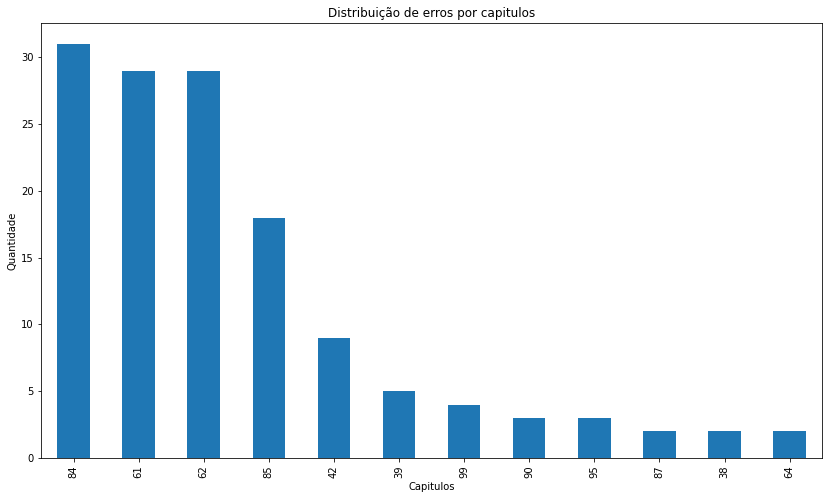

In [128]:
# Cria gráfico de barras
df_temp = pd.DataFrame()
df_temp = df_erros[df_erros['capitulo'] != df_erros.cap_resul]
values = df_temp['cap_resul'].value_counts()
threshold = 1  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot.bar(figsize=(14,8), title="Distribuição de erros por capitulos")
ax.set_xlabel("Capitulos")
ax.set_ylabel("Quantidade")
print(f"Quantidade de capítulos errados: {len(df_temp['cap_resul'].value_counts())}")

### 9.6 - Erros em posição - detalha quantidade de posições erradass e quantos erros por posição

In [86]:
total_err = {}
for posicao in posicoes_err:
    if total_err.get(posicao):
        total_err[posicao] += 1
    else:
        total_err[posicao] = 1

print(f'Total de posições erradas: {len(total_err.keys())}')
print(f'Total de erros em posiçõss: {len(posicoes_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['posicao'] == str(k).zfill(2)])
    print(f'Posição com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de posições erradas: 33
Total de erros em posiçõss: 524 erros

Posição com erro: 02 => 23 erro(s) em 1730 = 1.33%
Posição com erro: 01 => 5 erro(s) em 662 = 0.76%
Posição com erro: 17 => 20 erro(s) em 2294 = 0.87%
Posição com erro: 82 => 9 erro(s) em 1258 = 0.72%
Posição com erro: 07 => 11 erro(s) em 905 = 1.22%
Posição com erro: 09 => 22 erro(s) em 458 = 4.80%
Posição com erro: 06 => 22 erro(s) em 1262 = 1.74%
Posição com erro: 04 => 30 erro(s) em 2631 = 1.14%
Posição com erro: 05 => 9 erro(s) em 820 = 1.10%
Posição com erro: 14 => 58 erro(s) em 1518 = 3.82%
Posição com erro: 10 => 29 erro(s) em 584 = 4.97%
Posição com erro: 03 => 19 erro(s) em 2393 = 0.79%
Posição com erro: 18 => 3 erro(s) em 857 = 0.35%
Posição com erro: 26 => 5 erro(s) em 299 = 1.67%
Posição com erro: 08 => 7 erro(s) em 744 = 0.94%
Posição com erro: 15 => 9 erro(s) em 374 = 2.41%
Posição com erro: 11 => 5 erro(s) em 412 = 1.21%
Posição com erro: 13 => 4 erro(s) em 275 = 1.45%
Posição com erro: 12 => 4 erro(s)

Quantidade de posições errados: 51


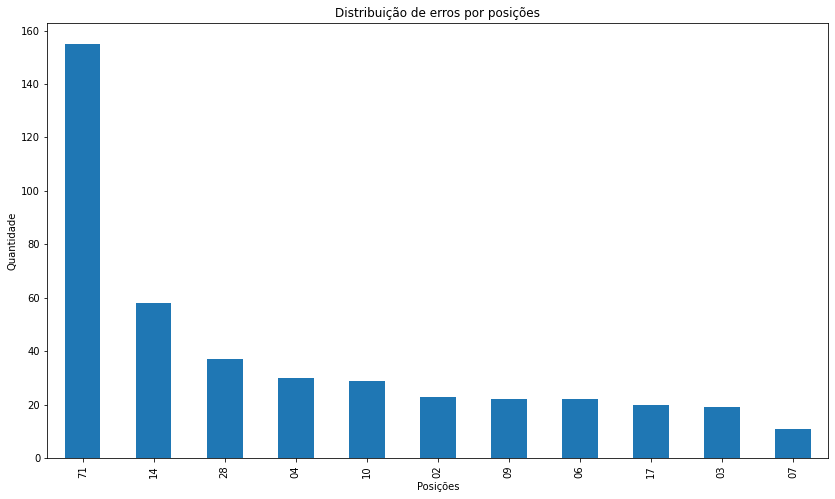

In [133]:
# Cria gráfico de barras
df_temp = pd.DataFrame()
df_temp = df_erros[(df_erros['capitulo'] == df_erros.cap_resul) & 
                   (df_erros['posicao'] != df_erros.pos_resul)]
df_temp.head()
values = df_temp['pos_resul'].value_counts()
threshold = 10  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot.bar(figsize=(14,8), title="Distribuição de erros por posições")
ax.set_xlabel("Posições")
ax.set_ylabel("Quantidade")
print(f"Quantidade de posições erradas: {len(df_temp['cap_resul'].value_counts())}")

### 9.7 - Erros em subposição, item e subitem - calcula o erro por categoria e a quantidade de erros em cada categoria

In [87]:
total_err = {}
for subposicao in subposicoes_err:
    if total_err.get(subposicao):
        total_err[subposicao] += 1
    else:
        total_err[subposicao] = 1

print(f'Total de subposições erradas: {len(total_err.keys())}')
print(f'Total de erros em subposiçõss: {len(subposicoes_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['subposicao'] == str(k).zfill(2)])
    print(f'Subposição com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de subposições erradas: 47
Total de erros em subposiçõss: 2867 erros

Subposição com erro: 50 => 27 erro(s) em 1001 = 2.70%
Subposição com erro: 32 => 77 erro(s) em 257 = 29.96%
Subposição com erro: 11 => 83 erro(s) em 507 = 16.37%
Subposição com erro: 30 => 146 erro(s) em 2627 = 5.56%
Subposição com erro: 10 => 57 erro(s) em 2517 = 2.26%
Subposição com erro: 39 => 137 erro(s) em 393 = 34.86%
Subposição com erro: 21 => 81 erro(s) em 974 = 8.32%
Subposição com erro: 63 => 34 erro(s) em 209 = 16.27%
Subposição com erro: 40 => 90 erro(s) em 824 = 10.92%
Subposição com erro: 92 => 21 erro(s) em 276 = 7.61%
Subposição com erro: 43 => 82 erro(s) em 167 = 49.10%
Subposição com erro: 52 => 11 erro(s) em 50 = 22.00%
Subposição com erro: 90 => 343 erro(s) em 2599 = 13.20%
Subposição com erro: 99 => 238 erro(s) em 901 = 26.42%
Subposição com erro: 14 => 16 erro(s) em 64 = 25.00%
Subposição com erro: 42 => 61 erro(s) em 156 = 39.10%
Subposição com erro: 22 => 34 erro(s) em 191 = 17.80%
Subpo

In [88]:
total_err = {}
for item in itens_err:
    if total_err.get(item):
        total_err[item] += 1
    else:
        total_err[item] = 1

print(f'Total de itens erradas: {len(total_err.keys())}')
print(f'Total de erros em itens: {len(itens_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['item'] == str(k)])
    print(f'Itens com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de itens erradas: 10
Total de erros em itens: 1553 erros

Itens com erro: 1 => 267 erro(s) em 4628 = 5.77%
Itens com erro: 9 => 764 erro(s) em 5794 = 13.19%
Itens com erro: 2 => 254 erro(s) em 1646 = 15.43%
Itens com erro: 0 => 27 erro(s) em 10732 = 0.25%
Itens com erro: 3 => 137 erro(s) em 1603 = 8.55%
Itens com erro: 8 => 18 erro(s) em 135 = 13.33%
Itens com erro: 4 => 37 erro(s) em 842 = 4.39%
Itens com erro: 6 => 25 erro(s) em 110 = 22.73%
Itens com erro: 7 => 21 erro(s) em 291 = 7.22%
Itens com erro: 5 => 3 erro(s) em 336 = 0.89%


In [89]:
total_err = {}
for subitem in subitens_err:
    if total_err.get(subitem):
        total_err[subitem] += 1
    else:
        total_err[subitem] = 1

print(f'Total de subitens erradas: {len(total_err.keys())}')
print(f'Total de erros em subitens: {len(subitens_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['subitem'] == str(k)])
    print(f'Subitens com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de subitens erradas: 10
Total de erros em subitens: 952 erros

Subitens com erro: 0 => 152 erro(s) em 19438 = 0.78%
Subitens com erro: 9 => 287 erro(s) em 2602 = 11.03%
Subitens com erro: 7 => 51 erro(s) em 258 = 19.77%
Subitens com erro: 2 => 86 erro(s) em 910 = 9.45%
Subitens com erro: 1 => 253 erro(s) em 2109 = 12.00%
Subitens com erro: 8 => 9 erro(s) em 50 = 18.00%
Subitens com erro: 4 => 33 erro(s) em 191 = 17.28%
Subitens com erro: 3 => 48 erro(s) em 343 = 13.99%
Subitens com erro: 5 => 32 erro(s) em 140 = 22.86%
Subitens com erro: 6 => 1 erro(s) em 76 = 1.32%


In [90]:
for i, row in enumerate(df_erros.iloc[:,0]):
    if df_erros.iloc[i,1] != df_erros.iloc[i,6]:
        print(f'errou capítulo {df_erros.iloc[i,1]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,2] != df_erros.iloc[i,7]:
        print(f'errou posicao {df_erros.iloc[i,2]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,3] != df_erros.iloc[i,8]:
        print(f'errou subposicao {df_erros.iloc[i,3]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,4] != df_erros.iloc[i,9]:
        print(f'errou item {df_erros.iloc[i,4]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,5] != df_erros.iloc[i,10]:
        print(f'errou subitem {df_erros.iloc[i,5]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')

errou item 3 - ncm: 32199030 - ncm_resul= 32199010
errou subitem 1 - ncm: 95030031 - ncm_resul= 95030030
errou item 0 - ncm: 42029900 - ncm_resul= 42029990
errou item 0 - ncm: 42029900 - ncm_resul= 42029910
errou item 1 - ncm: 49111010 - ncm_resul= 49111090
errou item 9 - ncm: 39209990 - ncm_resul= 39209910
errou capítulo 91 - ncm: 91021110 - ncm_resul= 42021110
errou item 0 - ncm: 39172900 - ncm_resul= 39172920
errou subitem 6 - ncm: 22041096 - ncm_resul= 22041090
errou subposicao 00 - ncm: 95030021 - ncm_resul= 95035021
errou subitem 1 - ncm: 95030021 - ncm_resul= 95030020
errou item 9 - ncm: 84186999 - ncm_resul= 84186919
errou subitem 7 - ncm: 95030097 - ncm_resul= 95030099
errou posicao 26 - ncm: 39269090 - ncm_resul= 39023290
errou subposicao 90 - ncm: 39269090 - ncm_resul= 39263290
errou posicao 04 - ncm: 64041100 - ncm_resul= 64021900
errou subposicao 12 - ncm: 91021290 - ncm_resul= 91021190
errou item 9 - ncm: 91021190 - ncm_resul= 91021110
errou capítulo 61 - ncm: 61059000 - 

errou subposicao 20 - ncm: 11062000 - ncm_resul= 11063000
errou subposicao 10 - ncm: 11071020 - ncm_resul= 11072020
errou subposicao 20 - ncm: 11072010 - ncm_resul= 11071010
errou subposicao 14 - ncm: 11081400 - ncm_resul= 11081300
errou subposicao 19 - ncm: 11081900 - ncm_resul= 11081300
errou item 0 - ncm: 12019000 - ncm_resul= 12019090
errou subposicao 42 - ncm: 12024200 - ncm_resul= 12024100
errou subposicao 10 - ncm: 12051090 - ncm_resul= 12051990
errou subposicao 10 - ncm: 12071090 - ncm_resul= 12079990
errou subposicao 29 - ncm: 12072900 - ncm_resul= 12079990
errou subposicao 30 - ncm: 12073090 - ncm_resul= 12079990
errou subposicao 40 - ncm: 12074090 - ncm_resul= 12079990
errou subposicao 50 - ncm: 12075010 - ncm_resul= 12079910
errou subposicao 50 - ncm: 12075090 - ncm_resul= 12079990
errou subposicao 70 - ncm: 12077090 - ncm_resul= 12079090
errou subposicao 91 - ncm: 12079190 - ncm_resul= 12079990
errou subposicao 10 - ncm: 12081000 - ncm_resul= 12089000
errou item 0 - ncm: 1

errou item 9 - ncm: 29242999 - ncm_resul= 29242939
errou subposicao 11 - ncm: 29251100 - ncm_resul= 29251920
errou subitem 1 - ncm: 29252921 - ncm_resul= 29252929
errou subitem 3 - ncm: 29252923 - ncm_resul= 29252922
errou item 9 - ncm: 29252990 - ncm_resul= 29252929
errou subposicao 20 - ncm: 29262000 - ncm_resul= 29269000
errou subitem 1 - ncm: 29263011 - ncm_resul= 29263012
errou item 2 - ncm: 29263020 - ncm_resul= 29263030
errou subitem 1 - ncm: 29269021 - ncm_resul= 29269029
errou subitem 6 - ncm: 29269026 - ncm_resul= 29269025
errou subitem 6 - ncm: 29269096 - ncm_resul= 29269090
errou subitem 9 - ncm: 29280019 - ncm_resul= 29280011
errou item 9 - ncm: 29280090 - ncm_resul= 29280020
errou item 1 - ncm: 29291010 - ncm_resul= 29291090
errou subitem 1 - ncm: 29291021 - ncm_resul= 29291029
errou subposicao 10 - ncm: 29291090 - ncm_resul= 29299090
errou subitem 0 - ncm: 29299090 - ncm_resul= 29299099
errou subposicao 70 - ncm: 29307000 - ncm_resul= 29309000
errou item 3 - ncm: 2930803

errou subposicao 93 - ncm: 38099390 - ncm_resul= 38099199
errou subposicao 10 - ncm: 38101010 - ncm_resul= 38109020
errou subposicao 10 - ncm: 38101020 - ncm_resul= 38109020
errou item 0 - ncm: 38109000 - ncm_resul= 38109020
errou subposicao 11 - ncm: 38111100 - ncm_resul= 38111900
errou item 0 - ncm: 38111900 - ncm_resul= 38111990
errou item 3 - ncm: 38112130 - ncm_resul= 38112110
errou subposicao 21 - ncm: 38112140 - ncm_resul= 38111920
errou subposicao 21 - ncm: 38112190 - ncm_resul= 38111990
errou subposicao 29 - ncm: 38112910 - ncm_resul= 38112130
errou subposicao 29 - ncm: 38112920 - ncm_resul= 38111920
errou subposicao 29 - ncm: 38112990 - ncm_resul= 38112190
errou subposicao 90 - ncm: 38119090 - ncm_resul= 38111990
errou item 0 - ncm: 38121000 - ncm_resul= 38121020
errou subposicao 20 - ncm: 38122000 - ncm_resul= 38123929
errou item 0 - ncm: 38123100 - ncm_resul= 38123120
errou item 1 - ncm: 38123911 - ncm_resul= 38123921
errou item 1 - ncm: 38123919 - ncm_resul= 38123929
errou

errou subposicao 25 - ncm: 52062500 - ncm_resul= 52063100
errou subposicao 31 - ncm: 52063100 - ncm_resul= 52064200
errou subposicao 32 - ncm: 52063200 - ncm_resul= 52064200
errou subposicao 33 - ncm: 52063300 - ncm_resul= 52064300
errou subposicao 34 - ncm: 52063400 - ncm_resul= 52064300
errou subposicao 35 - ncm: 52063500 - ncm_resul= 52064200
errou subposicao 41 - ncm: 52064100 - ncm_resul= 52064200
errou subposicao 44 - ncm: 52064400 - ncm_resul= 52064300
errou subposicao 45 - ncm: 52064500 - ncm_resul= 52064200
errou posicao 07 - ncm: 52071000 - ncm_resul= 52091010
errou posicao 07 - ncm: 52079000 - ncm_resul= 52099000
errou subposicao 12 - ncm: 52081200 - ncm_resul= 52081100
errou posicao 08 - ncm: 52081300 - ncm_resul= 52091910
errou posicao 08 - ncm: 52081900 - ncm_resul= 52091900
errou subposicao 22 - ncm: 52082200 - ncm_resul= 52082100
errou posicao 08 - ncm: 52082300 - ncm_resul= 52092910
errou posicao 08 - ncm: 52082900 - ncm_resul= 52092900
errou subposicao 32 - ncm: 52083

errou subposicao 49 - ncm: 62114900 - ncm_resul= 62113990
errou capítulo 62 - ncm: 62129000 - ncm_resul= 61129000
errou item 1 - ncm: 62139010 - ncm_resul= 62139090
errou item 0 - ncm: 62141000 - ncm_resul= 62141010
errou subposicao 20 - ncm: 62142000 - ncm_resul= 62141010
errou subposicao 40 - ncm: 62144000 - ncm_resul= 62143010
errou subposicao 10 - ncm: 63011000 - ncm_resul= 63014000
errou subposicao 20 - ncm: 63012000 - ncm_resul= 63019000
errou subposicao 30 - ncm: 63013000 - ncm_resul= 63019000
errou subposicao 40 - ncm: 63014000 - ncm_resul= 63013000
errou subposicao 90 - ncm: 63019000 - ncm_resul= 63012000
errou subposicao 10 - ncm: 63021000 - ncm_resul= 63023100
errou subposicao 21 - ncm: 63022100 - ncm_resul= 63022900
errou subposicao 22 - ncm: 63022200 - ncm_resul= 63023100
errou subposicao 29 - ncm: 63022900 - ncm_resul= 63029990
errou subposicao 31 - ncm: 63023100 - ncm_resul= 63025910
errou subposicao 32 - ncm: 63023200 - ncm_resul= 63023110
errou subposicao 39 - ncm: 630

errou item 0 - ncm: 82073000 - ncm_resul= 82073090
errou subposicao 60 - ncm: 82076000 - ncm_resul= 82073090
errou item 2 - ncm: 82077020 - ncm_resul= 82077090
errou subposicao 80 - ncm: 82078000 - ncm_resul= 82077090
errou item 0 - ncm: 82079000 - ncm_resul= 82079090
errou item 0 - ncm: 82089000 - ncm_resul= 82089090
errou item 1 - ncm: 82090019 - ncm_resul= 82090099
errou item 9 - ncm: 82100090 - ncm_resul= 82100010
errou subposicao 10 - ncm: 82111000 - ncm_resul= 82119300
errou subposicao 91 - ncm: 82119100 - ncm_resul= 82119390
errou item 1 - ncm: 82119210 - ncm_resul= 82119290
errou item 2 - ncm: 82119220 - ncm_resul= 82119290
errou item 1 - ncm: 82119310 - ncm_resul= 82119390
errou item 2 - ncm: 82119320 - ncm_resul= 82119390
errou subposicao 94 - ncm: 82119400 - ncm_resul= 82119390
errou subposicao 95 - ncm: 82119500 - ncm_resul= 82119390
errou item 1 - ncm: 82121010 - ncm_resul= 82121020
errou item 1 - ncm: 82122010 - ncm_resul= 82122020
errou item 0 - ncm: 82129000 - ncm_resul

errou subposicao 30 - ncm: 84793000 - ncm_resul= 84798919
errou subposicao 40 - ncm: 84794000 - ncm_resul= 84792090
errou subposicao 50 - ncm: 84795000 - ncm_resul= 84798990
errou subitem 0 - ncm: 84796000 - ncm_resul= 84796001
errou subposicao 71 - ncm: 84797100 - ncm_resul= 84798900
errou subposicao 79 - ncm: 84797900 - ncm_resul= 84798990
errou subposicao 81 - ncm: 84798190 - ncm_resul= 84798990
errou subposicao 82 - ncm: 84798210 - ncm_resul= 84798990
errou subposicao 82 - ncm: 84798290 - ncm_resul= 84798990
errou item 1 - ncm: 84799010 - ncm_resul= 84799031
errou subitem 0 - ncm: 84799090 - ncm_resul= 84799099
errou subposicao 10 - ncm: 84801000 - ncm_resul= 84806000
errou subposicao 20 - ncm: 84802000 - ncm_resul= 84803000
errou subposicao 30 - ncm: 84803000 - ncm_resul= 84806090
errou subposicao 50 - ncm: 84805000 - ncm_resul= 84806000
errou subposicao 60 - ncm: 84806000 - ncm_resul= 84804910
errou subposicao 71 - ncm: 84807100 - ncm_resul= 84804110
errou subposicao 79 - ncm: 84

errou subposicao 90 - ncm: 90189095 - ncm_resul= 90184995
errou subposicao 90 - ncm: 90189099 - ncm_resul= 90184999
errou item 0 - ncm: 90191000 - ncm_resul= 90191090
errou item 1 - ncm: 90192010 - ncm_resul= 90192030
errou item 2 - ncm: 90192020 - ncm_resul= 90192030
errou item 9 - ncm: 90192090 - ncm_resul= 90192030
errou item 1 - ncm: 90211010 - ncm_resul= 90211090
errou item 2 - ncm: 90211020 - ncm_resul= 90211090
errou subposicao 10 - ncm: 90211099 - ncm_resul= 90219080
errou item 1 - ncm: 90212110 - ncm_resul= 90212190
errou subposicao 29 - ncm: 90212900 - ncm_resul= 90213990
errou item 1 - ncm: 90213110 - ncm_resul= 90213190
errou subposicao 31 - ncm: 90213190 - ncm_resul= 90213990
errou item 1 - ncm: 90213919 - ncm_resul= 90213999
errou item 9 - ncm: 90213999 - ncm_resul= 90213980
errou subposicao 40 - ncm: 90214000 - ncm_resul= 90219082
errou subposicao 50 - ncm: 90215000 - ncm_resul= 90219091
errou subitem 9 - ncm: 90219019 - ncm_resul= 90219011
errou subposicao 90 - ncm: 902

errou item 1 - ncm: 84713012 - ncm_resul= 84713042
errou subitem 0 - ncm: 84714110 - ncm_resul= 84714111
errou posicao 17 - ncm: 85171231 - ncm_resul= 85711231
errou posicao 17 - ncm: 85171231 - ncm_resul= 85714131
errou posicao 17 - ncm: 85171231 - ncm_resul= 85714131
errou subitem 0 - ncm: 84714110 - ncm_resul= 84714111
errou subitem 0 - ncm: 84714110 - ncm_resul= 84714111
errou posicao 17 - ncm: 85176299 - ncm_resul= 85287199
errou subposicao 29 - ncm: 85182990 - ncm_resul= 85182100
errou posicao 17 - ncm: 85176299 - ncm_resul= 85287190
errou posicao 17 - ncm: 85176299 - ncm_resul= 85286299
errou subposicao 11 - ncm: 61071100 - ncm_resul= 61071900
errou posicao 17 - ncm: 85171231 - ncm_resul= 85711231
errou posicao 17 - ncm: 85171231 - ncm_resul= 85714131
errou posicao 17 - ncm: 85171231 - ncm_resul= 85714131
errou subitem 0 - ncm: 84714110 - ncm_resul= 84714111
errou item 4 - ncm: 85437040 - ncm_resul= 85437010
errou subposicao 70 - ncm: 85437099 - ncm_resul= 85436099
errou posicao